# Homework 4 - Genetic Networks #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

FONTSIZE = 13

## Negative Feedback Loop - Stress Response ##

Consider Stress molecules (S) that are controlled by Enzymes (E) which are controlled by Repressors (R). The concentrations of these components are regulated by the following equations:

$$ \frac{dR}{dt} = \frac{\gamma}{1+(\frac{R}{k})^h} - \frac{R}{\tau_R} + l $$
$$ \frac{dS}{dt} = \Theta_t - \gamma E S $$
$$ \frac{dE}{dt} = \frac{1}{1+(\frac{R}{k})^h} - \frac{E}{\tau_E} $$

Initial conditions: $ S(0) = E(0) = 0, R(0) = 0 $.

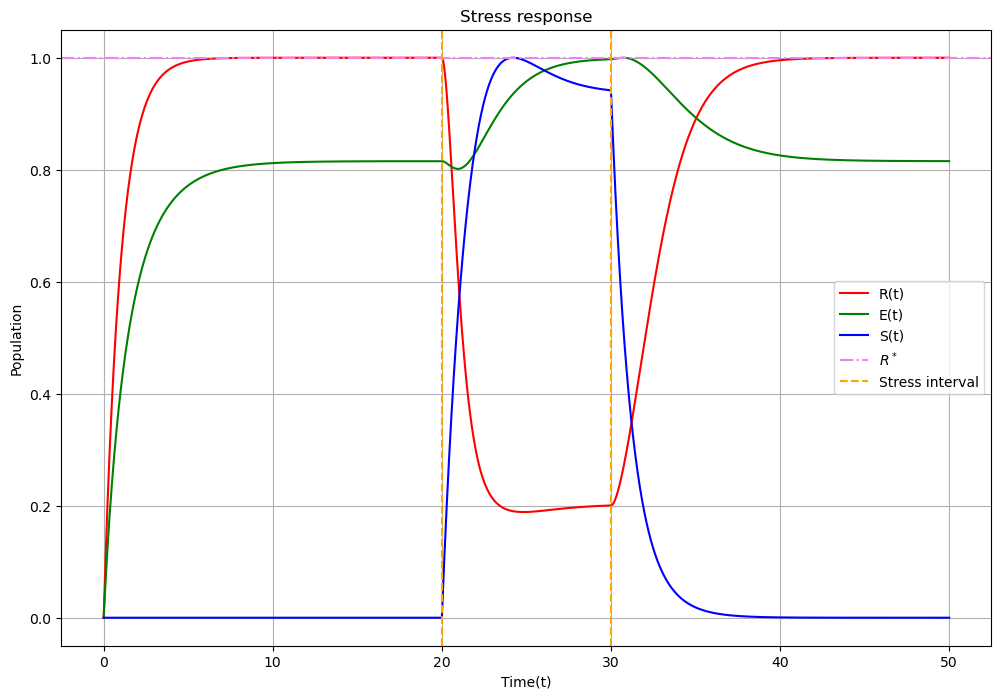

In [6]:
# initial conditions
R0 = 0
S0 = 0
E0 = 0

par = [0.5,1,1,0,1,2,[20,30]]

# we define Theta_t(t), which is the stress source, to be a step function that activates and spikes at a certain 
# point in time. This makes sense since the stress is usually caused by an abrupt change or signal

def Theta_t(t):
    #return np.where(np.isclose(t,t_th,rtol=1e-4), 1, 0)
    return np.where(t>0,1,0)

# define the equations
def system(y, t, Theta_t, par):
    # par[0] = gamma
    # par[1] = k
    # par[2] = h
    # par[3] = l
    # par[4] = tau_R
    # par[5] = tau_E
    # par [6] = t_th (t_s: stress point)
    
    R, E, S = y
    R_star = R * (1+S)
    drdt = par[0] / (1 + (S/par[1])**par[2]) - (R_star/par[4]) + par[3]
    dedt = 1 / (1+(R_star/par[1])**par[2]) - (E / par[5])
    dsdt = Theta_t(t-par[6][0])*(1-Theta_t(t-par[6][1])) - par[0] * E * S   
    return [drdt,dedt,dsdt]

# set the time space
t_s = np.linspace(0,50,5000)


# Solve 
R= odeint(system, [R0,E0,S0], t_s, args=(Theta_t,par))[:,0]
E = odeint(system, [R0,E0,S0], t_s, args=(Theta_t,par))[:,1]
S = odeint(system, [R0,E0,S0], t_s, args=(Theta_t,par))[:,2]

# Normalize
R = R / np.max(R)
E = E / np.max(E)
S = S / np.max(S)

plt.figure(figsize=(12,8))
plt.plot(t_s, R, c='r', label='R(t)')
plt.plot(t_s, E, c='g', label='E(t)')
plt.plot(t_s, S,  c='b', label='S(t)')
plt.axhline(R[-1]*(1+S[-1]), c='violet', linestyle='-.', label='$R^*$')
plt.axvline(par[6][0], c='orange', linestyle='--', label='Stress interval')
plt.axvline(par[6][1], c='orange', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Time(t)')
plt.ylabel('Population')
plt.title('Stress response')
plt.savefig('Figures/nfl.png')
# metti checkpoint per file salvato correttamente
plt.show()


As can be seen from the plot above, the dynamic described is a negative feedback loop (NFL). In fact, when we apply a positive impulse to S, E and R respond by increasing and decreasing, respectively. On the other hand, when the stress S goes back to zero, the other two curves go back to the stationary state.

## Genetic Network - Combining Positive and Negative Feedback Loops ##

An assumption is applied: since R is external to the loop, it is fixed R=1.

The equations that regulates this process are the folowing:

$$
\frac{dS}{dt} = \sigma \frac{T}{T+1} - \gamma S \frac{E}{E+1}
$$
$$
\frac{dT}{dt} = - \tau_T T + \frac{1}{1+(\frac{R_s}{k})^h} + l_T 
$$
$$
\frac{dE}{dt} = -\tau_E E + \frac{1}{1+(\frac{R_s}{k})^h} + l_E 
$$

where $R_s = \frac{RS}{1+S} $.

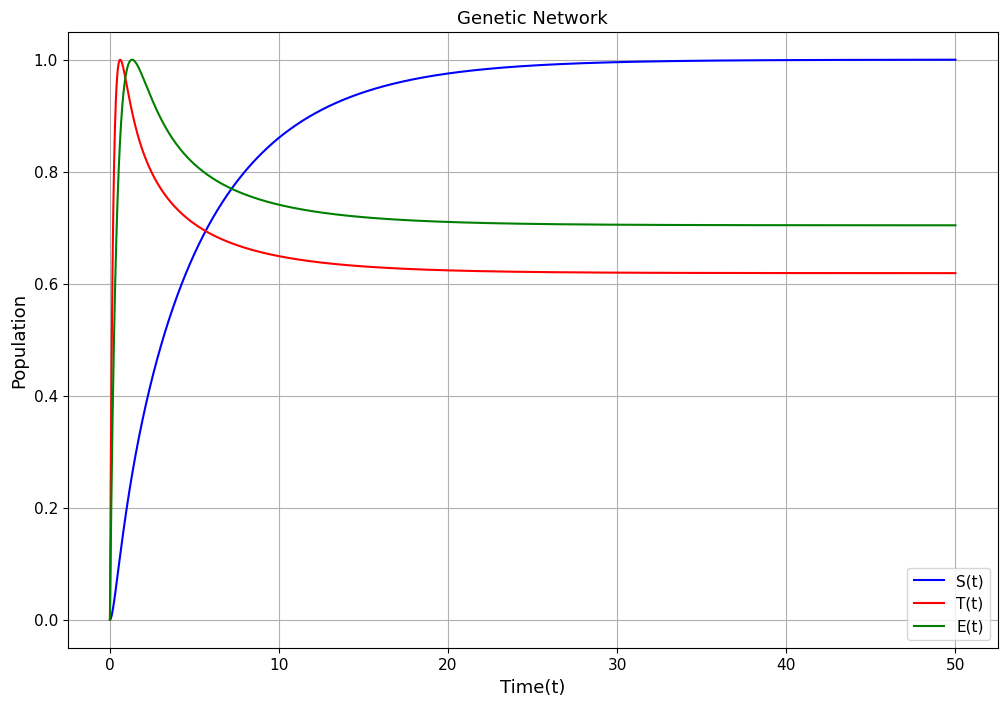

In [3]:
# initial conditions
S0 = 0
T0 = 0
E0 = 0

par = [0.8, # gamma
       0.2,   # k
       0.8,   # h
       0.4, # sigma
       1,   # R_const
       0.2,   # tau_T
       0.5,   # tau_E
       0.01,   # l_T
       0.01]    # l_E

def network(y, t, par):
    gamma, k, h, sigma, R, tau_T, tau_E, l_T, l_E= par
    
    S, T, E = y
    R_monod = R*S / (1 + S)
    dsdt = sigma*(T/(T+1)) - gamma*S*(E/(E+1))
    dtdt = -T/tau_T + 1 / (1 + (R_monod/k)**h) + l_T
    dedt = -E/tau_E + 1/(1+(R_monod/k)**h) + l_E
    return [dsdt, dtdt, dedt]

# set the time space
t_s = np.linspace(0,50,5000)

# Solve 
result = odeint(network, [S0,T0,E0], t_s, args=(par,))
S = result[:,0]
T = result[:,1]
E = result[:,2]

# Normalize
T = T / np.max(T)
E = E / np.max(E)
S = S / np.max(S)

plt.figure(figsize=(12,8))
plt.plot(t_s, S,  c='b', label='S(t)')
plt.plot(t_s, T, c='r', label='T(t)')
plt.plot(t_s, E,  c='g', label='E(t)')
plt.legend(fontsize=FONTSIZE-2)
plt.grid()
plt.xlabel('Time(t)', fontsize=FONTSIZE)
plt.ylabel('Population', fontsize=FONTSIZE)
plt.title('Genetic Network', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)
plt.savefig('Figures/network_stress.png')
plt.show()

If no perturbation is present, the system quickly goes to stationarity. Moreover, here is exemplified the combination of negative and positive feedback loops: E and T firstly spike to maximum concentration and then decrease to the stationarity level due to the increment in S, since they depend on S trough the term $R_s$. At the same time, E and T are responsible of the slope of S.
On the biological level, this is exemplified by T being a transport regulator protein for the stress molecules and E being an activator for the metabolism that lowers stress levels. Lastly, R is the regulator of T and E, exemplified by the term $R_s$.

Now we try to add a stress impulse, as we did for the NFL:

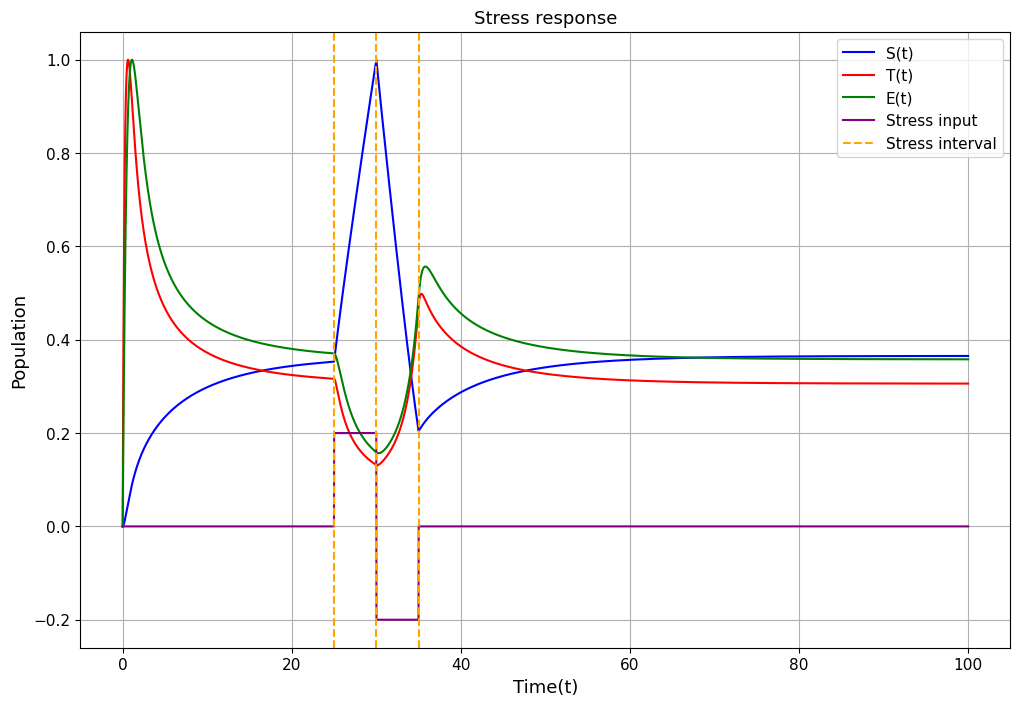

In [7]:
def Theta_t(t):
    return np.where(t>0,1,0)

# initial conditions
S0 = 0
T0 = 0
E0 = 0

par = [0.8, # gamma
       0.2,   # k
       2,   # h
       0.9, # sigma
       1,   # R_const
       0.2,   # tau_T
       0.5,   # tau_E
       0.01,   # l_T
       0.01,    # l_E
       [25,30]]   # t_th

# altro set di parametri
p = [0.5, .5, 1.0, 0.7, 1, 2.0, 1.0, 0.0, 0.0]

def network(y, t, Theta_t, par):
    gamma, k, h, sigma, R, tau_T, tau_E, l_T, l_E, t_th= par
    
    S, T, E = y
    R_monod = R*S / (1 + S)
    dsdt = 0.2*Theta_t(t-t_th[0])*(1-Theta_t(t-t_th[1]))+0.2*(-Theta_t(t-t_th[0]-5)*(1-Theta_t(t-t_th[1]-5))) + sigma*(T/(T+1)) - gamma*S*(E/(E+1))
    dtdt = - T/tau_T + 1 / (1 + (R_monod/k)**h) + l_T
    dedt = - E/tau_E + 1/(1+(R_monod/k)**h) + l_E
    return [dsdt, dtdt, dedt]

# set the time space
t_s = np.linspace(0,100,10000)

# Solve 
result = odeint(network, [S0,T0,E0], t_s, args=(Theta_t, par))
S = result[:,0]
T = result[:,1]
E = result[:,2]

# Normalize
T = T / np.max(T)
E = E / np.max(E)
S = S / np.max(S)

plt.figure(figsize=(12,8))
plt.plot(t_s, S,  c='b', label='S(t)')
plt.plot(t_s, T, c='r', label='T(t)')
plt.plot(t_s, E,  c='g', label='E(t)')
plt.plot(t_s, 0.2*Theta_t(t_s-par[9][0])*(1-Theta_t(t_s-par[9][1]))
         +0.2*(-Theta_t(t_s-par[9][0]-5)*(1-Theta_t(t_s-par[9][1]-5))),
         c='purple', label='Stress input')
plt.axvline(par[9][0], c='orange', linestyle='--', label='Stress interval')
plt.axvline(par[9][1], c='orange', linestyle='--')
plt.axvline(par[9][1]+5, c='orange', linestyle='--')
plt.legend(fontsize=FONTSIZE-2, loc='best')
plt.grid()
plt.xlabel('Time(t)', fontsize=FONTSIZE)
plt.ylabel('Population', fontsize=FONTSIZE)
plt.title('Stress response', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)
plt.savefig('Figures/network_stress.png')
plt.show()

Here we can see how a perturbation in the stress signal triggers an immediate response in the other two curves (E and T) which decrease rapidly as S inreases rapidly. Conversely, when the impulse on S is inverted, E and T spike up, while S drops down. Lastly, when the impulse is turned off, all the curves slowly lay on their stationary value.

It is worth mentioning how this system is highly sensible to the parameter values and considerably less on the initial conditions.